In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import preprocess as pp
from anndata import AnnData
import vanilla_vae

In [2]:
# --------------Parameters-------------------
embedding_dim = 2
hidden_dim = 512
k_fold = 5
cross_validation = False
num_epoch=30
batch_size=512
feature_selection = True
num_genes = 36601
# --------------Plotting---------------------
plot_loss = True
plot_embedding_space = True
plot_confusion_matrix = True

D = pd.read_csv('C:/Users/xbh04/Desktop/distance_matrix_bcell_ABCs.csv').iloc[:, 1:]
D = torch.tensor(D.values, dtype=float)

dataset = sc.read_h5ad("C:/Users/xbh04/Desktop/b-cells.h5ad")
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'MNP/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'T/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'ABCs']
dataset_Pro_B = dataset[dataset.obs['Manually_curated_celltype'] == 'Pro-B']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'Pro-B']

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=cross_validation, k_fold=k_fold)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=100)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

In [4]:
def train_nn(l_metric=2, l_pl = 8, epochs = num_epoch, D_metric=None, D_cost=D, cuda=1):
    D_metric = D_metric.cuda()
    model_vae = vanilla_vae.VanillaVAE(100, 2, [128, 64, 32]).cuda()
    model = prototypical_network.LearntPrototypes(model_vae, n_prototypes= D_metric.shape[0],
                                prototypes=None, embedding_dim=embedding_dim, device='cuda').cuda()
    
    delta = DistortionLoss(D_metric)
    criterion = nn.CrossEntropyLoss()
    ac = cost.AverageCost(D_cost)

    opt = torch.optim.Adam(model.parameters())
    if plot_loss:
        losses = {'loss_xe':[],'loss_disto':[],'loss_pl':[],'loss_vae':[], 'loss_reconst':[], 'loss_kl':[]}
    if plot_embedding_space:
        embedding_space = {'training_embeddings':[],'training_labels':[],'testing_embeddings':[],'testing_pred_labels':[],'testing_true_labels':[]}
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()

        model.train()
        t0 = time.time()
        if plot_loss:
            batch_losses = {'loss_xe':[],'loss_disto':[],'loss_pl':[],'loss_vae':[], 'loss_reconst':[], 'loss_kl':[]}
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            opt.zero_grad()
            vae_loss = model_vae.loss_function(x_hat, x, mean, log_var, decoder_mu,decoder_log_var, M_N=1)
            pl_loss = PL(centers = model.prototypes.data)
            pl_loss_ = pl_loss(embeddings, y)
            if epoch == epochs and plot_embedding_space:
                embedding_space['training_embeddings'].extend(embeddings)
                embedding_space['training_labels'].extend(y)
            loss = criterion(out, y) +  l_metric * delta(model.prototypes) + l_pl*pl_loss_ + vae_loss['loss']
            
            if plot_loss:
                batch_losses['loss_xe'].append(criterion(out, y).detach().cpu())
                batch_losses['loss_disto'].append((l_metric * delta(model.prototypes)).detach().cpu())
                batch_losses['loss_pl'].append(l_pl*pl_loss_.detach().cpu())
                batch_losses['loss_vae'].append(vae_loss['loss'].detach().cpu())
                batch_losses['loss_reconst'].append(vae_loss['Reconstruction_Loss'].detach().cpu())
                batch_losses['loss_kl'].append(vae_loss['KLD'].detach().cpu())

            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
            AC_meter.add(ac(pred.cpu(),y.cpu()))
        
        if plot_loss:
            losses['loss_xe'].append(np.array(batch_losses['loss_xe']).mean())
            losses['loss_disto'].append(np.array(batch_losses['loss_disto']).mean())
            losses['loss_pl'].append(np.array(batch_losses['loss_pl']).mean())
            losses['loss_vae'].append(np.array(batch_losses['loss_vae']).mean())
            losses['loss_reconst'].append(np.array(batch_losses['loss_reconst']).mean())
            losses['loss_kl'].append(np.array(batch_losses['loss_kl']).mean())

        t1 = time.time()
        
        print('Train ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            with torch.no_grad():
                out, embedding_y, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            pred = out.detach()
            if epoch == epochs and plot_embedding_space:
                embedding_space['testing_embeddings'].extend(embedding_y)
                embedding_space['testing_pred_labels'].extend(pred.cpu().numpy())
                embedding_space['testing_true_labels'].extend(y)
            ER_meter.add(pred.cpu(),y)
            AC_meter.add(ac(pred.cpu(),y))
        t1 = time.time()
        print('Test ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))
        results = {}
        results['model'] = model
        if plot_loss:
            results['losses'] = losses
        if plot_embedding_space:
            results['embedding_space'] = embedding_space
    return results

In [5]:
kfold = KFold(n_splits=k_fold, shuffle=True)
# Start print
print('--------------------------------')
model_list = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')

      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      
      dataloader_training = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=train_subsampler)
      dataloader_testing = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=test_subsampler)

      results = train_nn(D_metric=D, l_metric=1)
      model_list.append(results)
      
      if not cross_validation:
            break

--------------------------------
FOLD 0
--------------------------------
Epoch 1
Train ER 48.38, AC 1.044, time 1.6s
Test ER 30.81, AC 0.690, time 0.1s
Epoch 2
Train ER 30.42, AC 0.677, time 0.9s
Test ER 27.98, AC 0.618, time 0.1s
Epoch 3
Train ER 25.68, AC 0.562, time 1.0s
Test ER 22.46, AC 0.485, time 0.1s
Epoch 4
Train ER 21.42, AC 0.461, time 0.9s
Test ER 19.67, AC 0.423, time 0.1s
Epoch 5
Train ER 17.39, AC 0.375, time 0.9s
Test ER 15.45, AC 0.335, time 0.1s
Epoch 6
Train ER 14.12, AC 0.305, time 0.9s
Test ER 12.72, AC 0.273, time 0.1s
Epoch 7
Train ER 11.62, AC 0.250, time 1.0s
Test ER 10.23, AC 0.232, time 0.1s
Epoch 8
Train ER 9.10, AC 0.197, time 1.0s
Test ER 9.46, AC 0.200, time 0.1s
Epoch 9
Train ER 7.65, AC 0.164, time 1.0s
Test ER 6.80, AC 0.152, time 0.1s
Epoch 10
Train ER 6.77, AC 0.144, time 1.0s
Test ER 7.32, AC 0.157, time 0.1s
Epoch 11
Train ER 6.15, AC 0.130, time 0.9s
Test ER 5.96, AC 0.126, time 0.1s
Epoch 12
Train ER 5.36, AC 0.114, time 1.0s
Test ER 5.64, AC 0.1

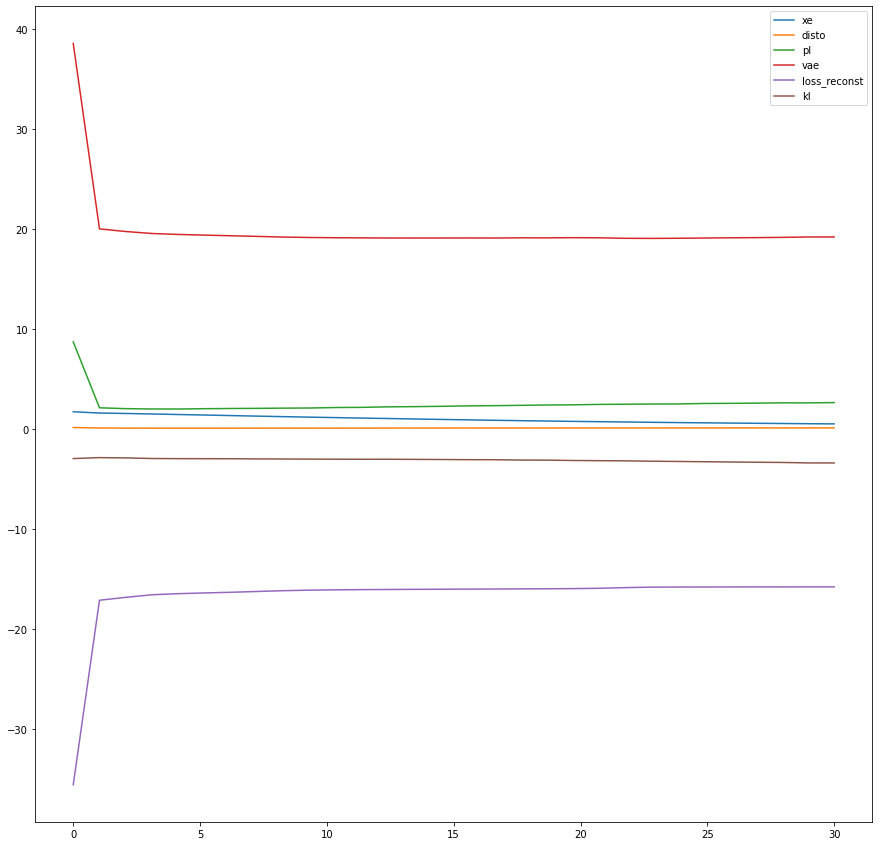

In [6]:
if plot_loss:
    plt.figure(figsize=(15, 15))
    ax = plt.axes()

    x = np.linspace(0, len(results.get('losses')['loss_pl']), len(results.get('losses')['loss_pl']))
    plt.plot(x, np.array(results.get('losses')['loss_xe']), label='xe')
    plt.plot(x, np.array(results.get('losses')['loss_disto']), label='disto')
    plt.plot(x, np.array(results.get('losses')['loss_pl']), label='pl')
    plt.plot(x, np.array(results.get('losses')['loss_vae']), label='vae') 
    plt.plot(x, np.array(results.get('losses')['loss_reconst']), label='loss_reconst') 
    plt.plot(x, np.array(results.get('losses')['loss_kl']), label='kl') 
    plt.legend()

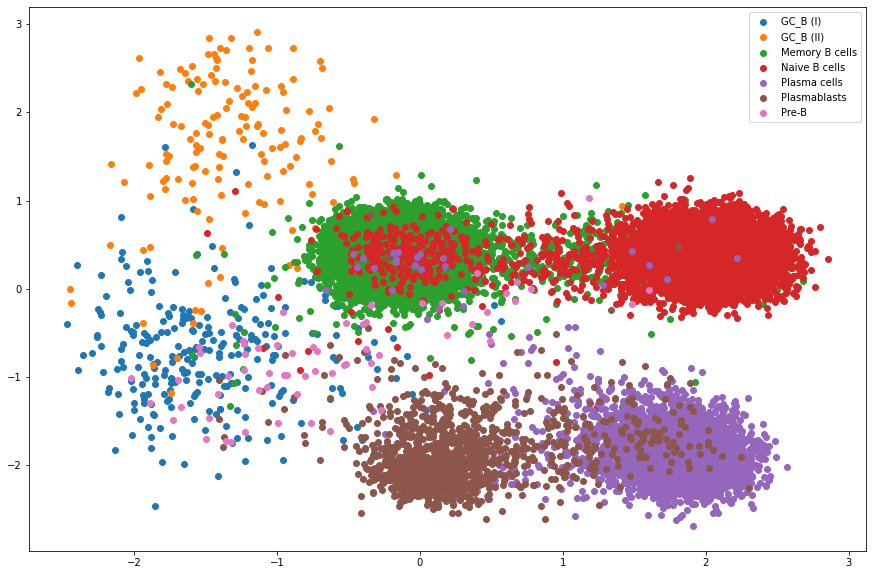

In [7]:
# Training
training_embeddings = results.get('embedding_space')['training_embeddings']
training_embeddings_labels = results.get('embedding_space')['training_labels']
for i in range(len(training_embeddings_labels)):
    if type(training_embeddings[i]) != np.ndarray:
        training_embeddings[i] = training_embeddings[i].detach().cpu().numpy()
    if type(training_embeddings_labels[i]) != np.ndarray:
        training_embeddings_labels[i] = training_embeddings_labels[i].detach().cpu().numpy()
if plot_embedding_space:
    training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(15, 10))
    for color in np.unique(np.array(training_embeddings_labels)):
        i = np.where(np.array(training_embeddings_labels) == color)
        ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
    ax.legend()
    plt.show()

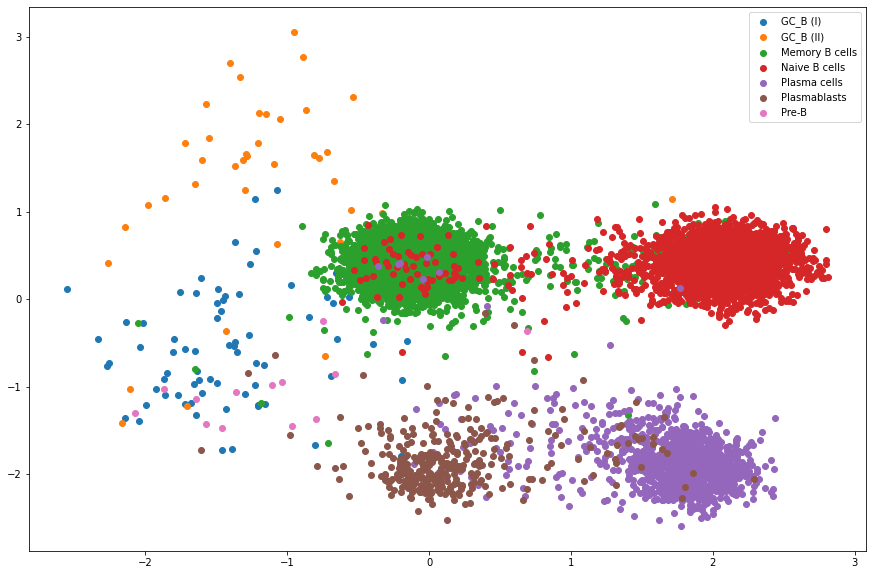

In [8]:
# Testing
test_embeddings = results.get('embedding_space')['testing_embeddings']
test_true_labels = results.get('embedding_space')['testing_true_labels']
if type(test_embeddings[0]) != np.ndarray:
    for i in range(len(test_embeddings)):
        test_embeddings[i] = test_embeddings[i].cpu().numpy()
        test_true_labels[i] = test_true_labels[i].cpu()
test_true_labels=encoder_celltype.inverse_transform(test_true_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(15, 10))
    for color in np.unique(np.array(test_true_labels)):
        i = np.where(test_true_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    ax.legend()
    plt.show()

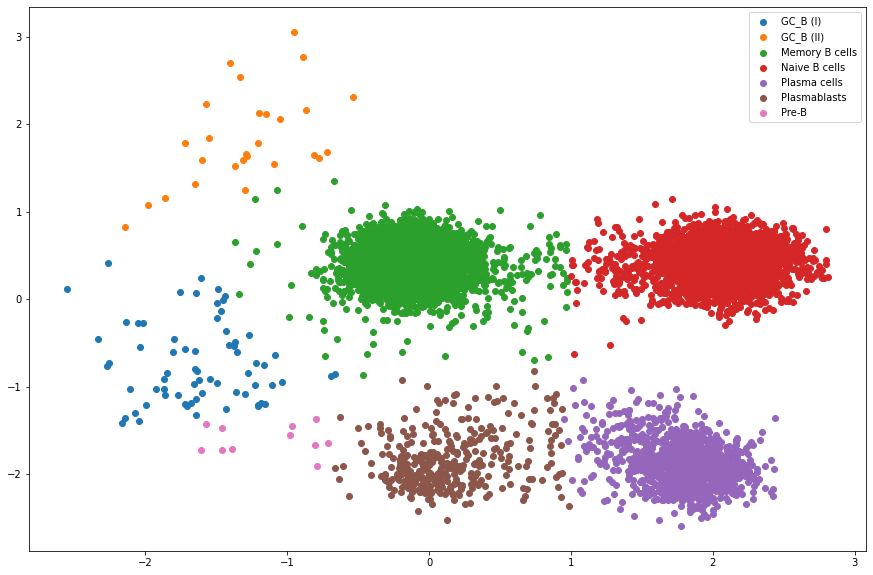

In [9]:
# Testing pred labels
test_embeddings = results.get('embedding_space')['testing_embeddings']
test_pred_labels = results.get('embedding_space')['testing_pred_labels'].copy()
for i in range(len(test_pred_labels)):
    test_pred_labels[i] = test_pred_labels[i].argmax()

test_pred_labels=encoder_celltype.inverse_transform(test_pred_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(15, 10))
    for color in np.unique(np.array(test_pred_labels)):
        i = np.where(test_pred_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    ax.legend()
    plt.show()

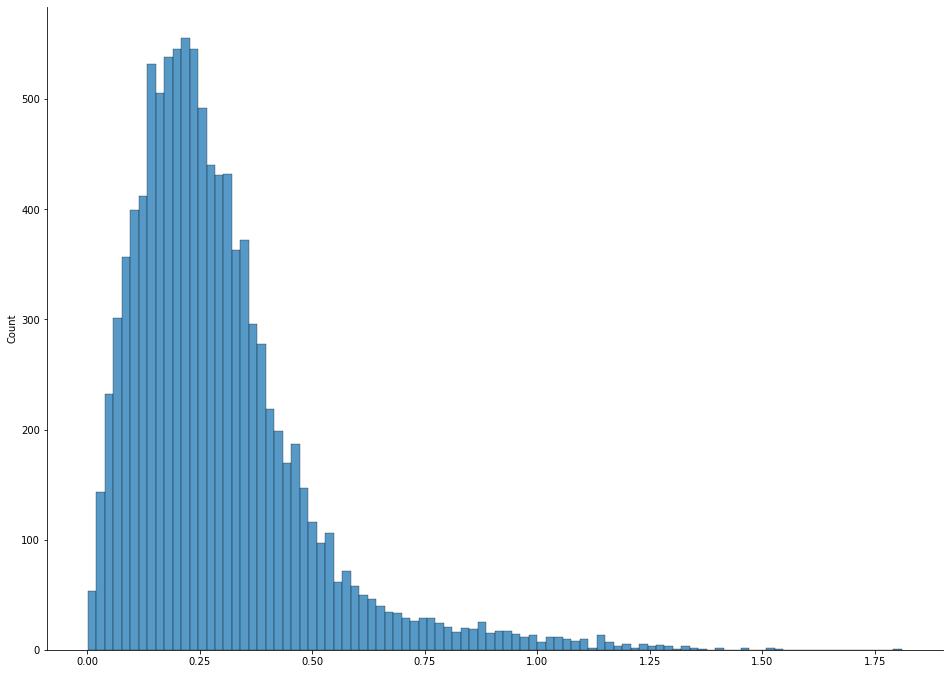

In [10]:
test_pred_dists = results.get('embedding_space')['testing_pred_labels'].copy()
test_pred_labels = encoder_celltype.fit_transform(test_pred_labels)
test_true_labels = encoder_celltype.fit_transform(test_true_labels)
true_pos = []
for i in range(len(test_pred_dists)):
    test_pred_dists[i] = -test_pred_dists[i][test_pred_labels[i]]
    if test_pred_labels[i] == test_true_labels[i]:
        true_pos.append(test_pred_dists[i])

g = sns.displot(test_pred_dists)
g.fig.set_size_inches(15,10)

In [11]:
sc.pp.normalize_total(dataset_Pro_B, target_sum = 1e4)
sc.pp.log1p(dataset_Pro_B)

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


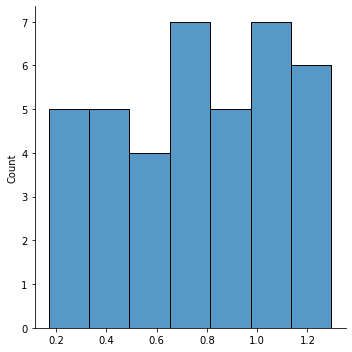

In [12]:
dataset_Pro_B_pca = AnnData(pca.transform(dataset_Pro_B.X))
dataset_Pro_B = AnnLoader(dataset_Pro_B_pca, batch_size=512)
for batch in dataset_Pro_B:
    x = batch.X.cuda()
    model = results.get('model')
    with torch.no_grad():
        out_Pro_B, embedding_Pro_B, y_hat, mean, log_var, decoder_mean, decoder_log_var = model(x)
    pred = out_Pro_B.detach()
Pro_B_pred = pred.cpu().numpy()
for i in range(len(Pro_B_pred)):
    Pro_B_pred[i] = -Pro_B_pred[i].max()
Pro_B_pred = Pro_B_pred[:, 0]
g = sns.displot(Pro_B_pred)
g.fig.set_size_inches(5,5)

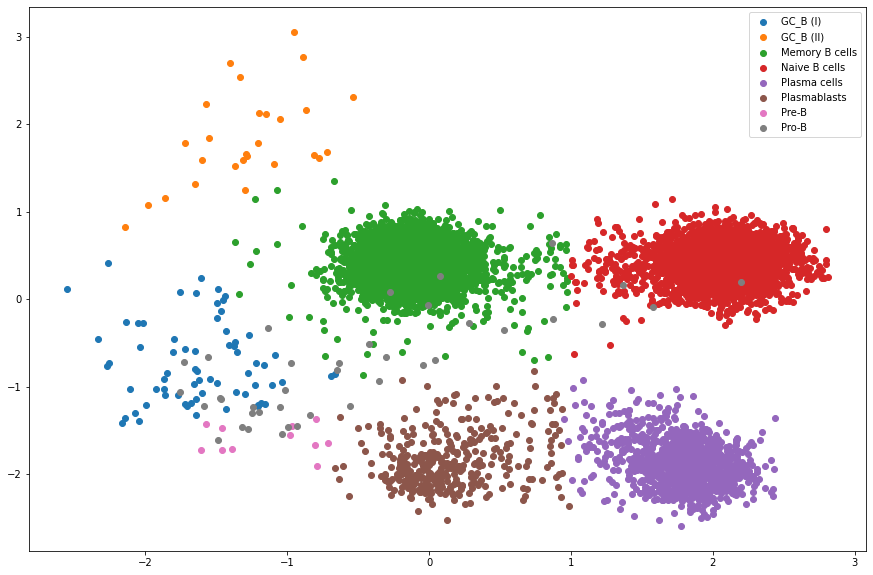

In [13]:
if type(embedding_Pro_B) != np.ndarray:
    embedding_Pro_B = embedding_Pro_B.cpu().numpy()
    test_pred_labels = encoder_celltype.inverse_transform(test_pred_labels)
fig, ax = plt.subplots(figsize=(15, 10))
for color in np.unique(np.array(test_pred_labels)):
    i = np.where(test_pred_labels == color)
    ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    
ax.scatter(np.array(embedding_Pro_B)[:,0], np.array(embedding_Pro_B)[:,1], label='Pro-B')
ax.legend()
plt.show()

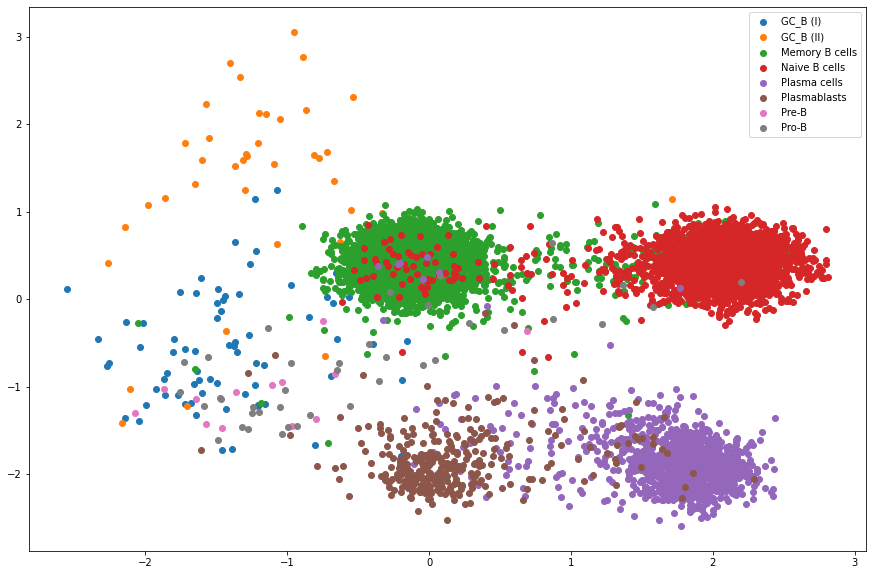

In [14]:
if type(embedding_Pro_B) != np.ndarray:
    embedding_Pro_B = embedding_Pro_B.cpu().numpy()
test_true_labels = encoder_celltype.inverse_transform(test_true_labels)
fig, ax = plt.subplots(figsize=(15, 10))
for color in np.unique(np.array(test_true_labels)):
    i = np.where(test_true_labels == color)
    ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    
ax.scatter(np.array(embedding_Pro_B)[:,0], np.array(embedding_Pro_B)[:,1], label='Pro-B')
ax.legend()
plt.show()

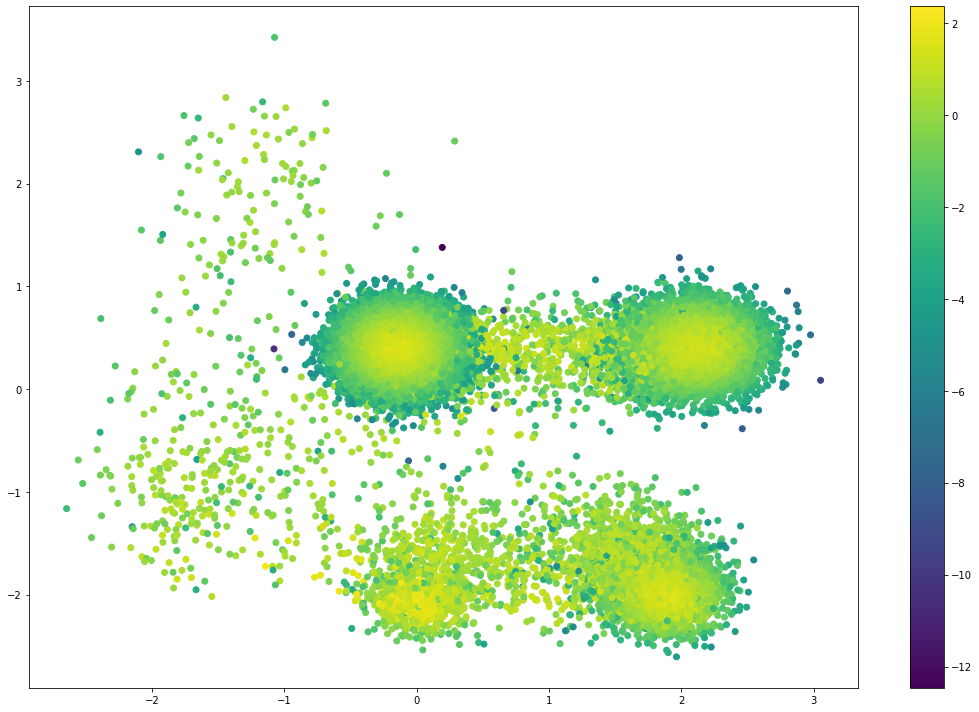

In [38]:
# Training
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[train_ids].X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=embedding_likelihoods)
    fig.colorbar(points)
    plt.show()

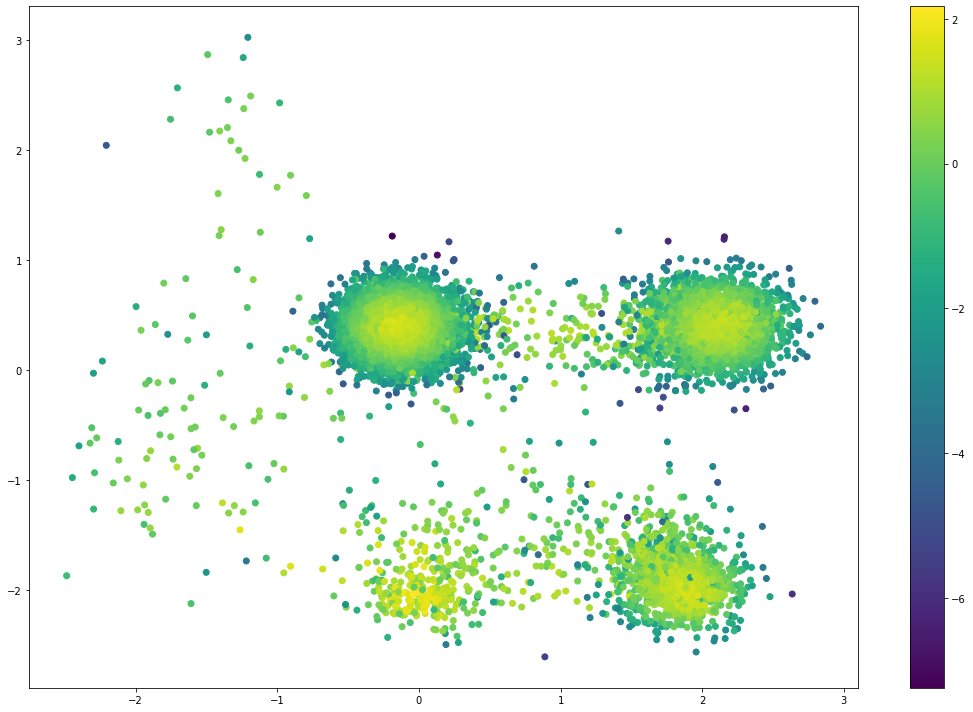

In [39]:
# Training
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_ids].X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=embedding_likelihoods)
    fig.colorbar(points)
    plt.show()

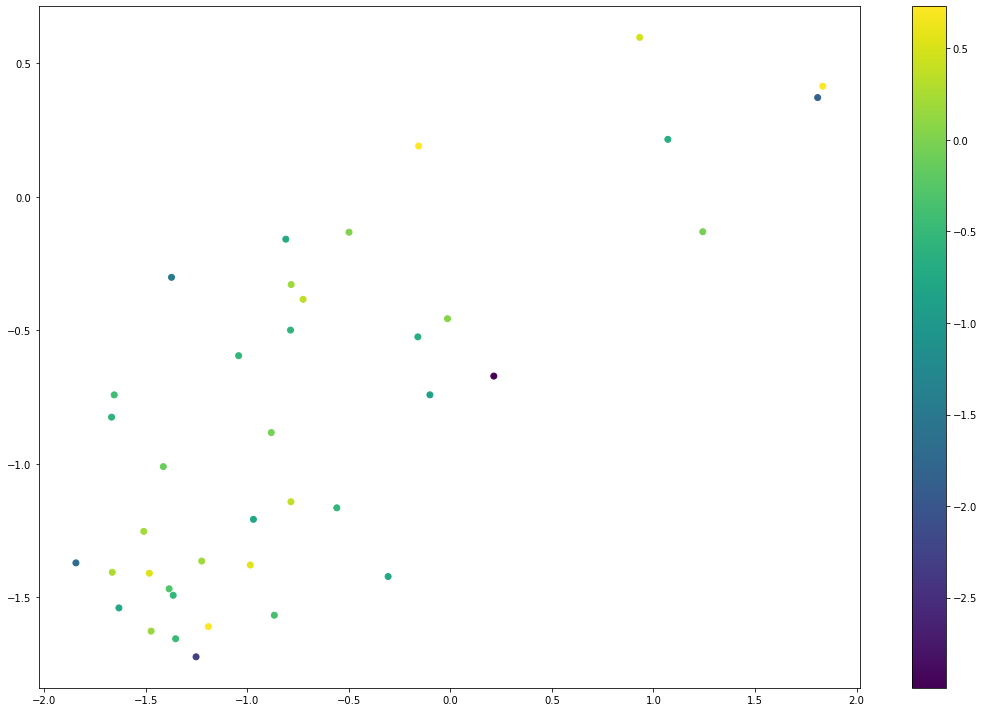

In [41]:
# Training
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset_Pro_B_pca.X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=embedding_likelihoods)
    fig.colorbar(points)
    plt.show()